In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from IPython.core.display import display, HTML, clear_output
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
import pandas as pd
import numpy as np
import numpy.polynomial.polynomial as poly
import scipy
from scipy import integrate, interpolate, misc
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import sys
import os

import seaborn as sns


In [4]:
sys.path.append("/home/chase/codes/python_functions/")
import plotting as my_plot

sys.path.append(os.path.realpath('./pyilt/'))
import ilt

import my_dls_code as dls

sys.path.append("./previous/lcurve-master/")
import lcurve_functions as lcurve_fun

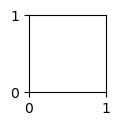

In [5]:
fig, ax = my_plot.instantiate_fig(1, 1)

# Notes
- feed_native samples are obviously in the buffers in which the samples were supplied
- pafvin_small_250 was ~3/4 the conjugation buffer, ~1/4 the standard digest buffer
- pafvin_mab_750 was in the SEC buffer
- all other samples were in the conjugation buffer
- concentrations of pafvin samples are approximate estimates, hccf samples were controlled

In [6]:
# I used pseudo-cross-correlation with the PAFVIN samples
files = {
    'hccf_feed_native':'./data/data_2/hccf-feed-3d.dat',
    'hccf_feed_700':'./data/data_2/hccf-0700.dat',
    'hccf_large_700':'./data/data_1/large-0700.dat',
    'hccf_small_700':'./data/data_1/small-0700.dat',
    'hccf_mab_700':'./data/data_1/mab-0700.dat',
    'hccf_mab_3643':'./data/data_1/mab-3643.dat',
    'pafvin_feed_native':'./data/data_4/pafvin-feed-3d.dat',
    'pafvin_large_500':'./data/data_4/pafvin-large-0500.dat',
    'pafvin_small_250':'./data/data_5/pafvin-s-250-3.dat',
    'pafvin_mab_750':'./data/data_5/pafvin-m-750.dat',
}

In [7]:
images_folder = './images_complete/'

data = {}
for name, file_path in files.items():
    data[name] = dls.data_file(file_path)

In [8]:
# Descriptive plots

for name in data.keys():
    fig, ax = data[name].make_count_rate_plot()
    plt.savefig(f'./{images_folder}/{name}_1_count_rate.png', 
                dpi=300, bbox_inches='tight')
    
    fig, ax = data[name].make_count_rate_histogram()
    plt.savefig(f'./{images_folder}/{name}_2_count_rate_hist.png', 
                dpi=300, bbox_inches='tight')
    
    fig, ax = data[name].make_g2_plot()
    plt.savefig(f'./{images_folder}/{name}_3_g2.png', 
                dpi=300, bbox_inches='tight')
    
    plt.close('all')

In [9]:
# Fit data

for name in data.keys():
    data[name].get_optimal_alpha(low_r_bound=0.5, up_r_bound=1000)

In [10]:
# Fit plots

for name in data.keys():
    fig, ax = data[name].draw_L_curve()
    plt.savefig(f'./{images_folder}/{name}_4_L_curve.png', 
                dpi=300, bbox_inches='tight')
    
    fig, ax = data[name].plot_g1_fit()
    plt.savefig(f'./{images_folder}/{name}_5_g1_fit.png', 
                dpi=300, bbox_inches='tight')

    fig, ax = data[name].make_gamma_dist_plot()
    plt.savefig(f'./{images_folder}/{name}_6_G_gamma_dist.png', 
                dpi=300, bbox_inches='tight')
    
    fig, ax = data[name].make_rh_dist_plot()
    plt.savefig(f'./{images_folder}/{name}_7_Rh_dist.png', 
                dpi=300, bbox_inches='tight')
                
    plt.close('all')

In [11]:
# data[name].rh_vals

In [12]:
alpha_vals = []
for name in data.keys():
    alpha_vals.append([name, data[name].alpha_opt])
df_alpha = pd.DataFrame(alpha_vals, columns=['name', 'alpha'])

In [13]:
offset = 0.2
df_alpha['y_vals'] = 1.0
df_alpha.at[2, 'y_vals'] += offset
df_alpha.at[7, 'y_vals'] += offset

df_alpha

,name,alpha,y_vals
0,hccf_feed_native,0.372759,1.0
1,hccf_feed_700,0.268270,1.0
2,hccf_large_700,0.372759,1.2
3,hccf_small_700,0.051795,1.0
4,hccf_mab_700,0.100000,1.0
5,hccf_mab_3643,0.138950,1.0
6,pafvin_feed_native,0.517947,1.0
7,pafvin_large_500,0.100000,1.2
8,pafvin_small_250,0.037276,1.0
9,pafvin_mab_750,0.071969,1.0


In [14]:
# df_alpha.to_excel('./optimal_alpha.xlsx', index=False)

(1e-05, 100.0)

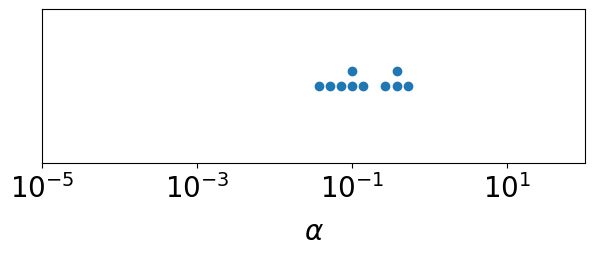

In [15]:
fig, ax = my_plot.instantiate_fig(y=2, xlabel=r'$\alpha$')
ax.yaxis.set_visible(False) 
ax.scatter(df_alpha.alpha, df_alpha.y_vals)
ax.set_ylim(0.0, 2.0)
ax.set_xscale('log')
ax.set_xlim(1e-5, 1e2)

# plt.savefig(f'./{images_folder}/alpha_optimal_vals.png', dpi=300, bbox_inches='tight')

In [16]:
labels = ['Feed', 'Large agg.', 'Small agg.', 'mAb']

In [17]:
# for i, name in enumerate(['hccf_feed_native', 'hccf_large_700', 'hccf_small_700', 'hccf_mab_700']):
#     if i == 0:
#         fig, ax = data[name].make_rh_dist_plot(label=labels[i])
#     else:
#         fig, ax = data[name].make_rh_dist_plot(fig, ax, labels[i])
        
# my_plot.set_layout(fig, ax, legend=True)
# plt.savefig(f'./{images_folder}/All_HCCF_7_Rh_dist.png', dpi=300, bbox_inches='tight')

# for i, name in enumerate(['hccf_feed_native', 'hccf_large_700', 'hccf_small_700', 'hccf_mab_700']):
#     if i == 0:
#         fig, ax = data[name].make_rh_dist_plot(label=labels[i], normalize=True)
#     else:
#         fig, ax = data[name].make_rh_dist_plot(fig, ax, labels[i], normalize=True)
        
# my_plot.set_layout(fig, ax, legend=True)
# plt.savefig(f'./{images_folder}/All_HCCF_7_Rh_dist_normalized.png', dpi=300, bbox_inches='tight')

In [18]:
# for i, name in enumerate(['pafvin_feed_native', 'pafvin_large_500', 'pafvin_small_250', 'pafvin_mab_750']):
#     if i == 0:
#         fig, ax = data[name].make_rh_dist_plot(label=labels[i], normalize=True)
#     else:
#         fig, ax = data[name].make_rh_dist_plot(fig, ax, labels[i], normalize=True)
        
# my_plot.set_layout(fig, ax, legend=True, fontsize=18)
# plt.savefig(f'./{images_folder}/All_PAFVIN_7_Rh_dist_normalized.png', dpi=300, bbox_inches='tight')

# for i, name in enumerate(['pafvin_feed_native', 'pafvin_large_500', 'pafvin_small_250', 'pafvin_mab_750']):
#     if i == 0:
#         fig, ax = data[name].make_rh_dist_plot(label=labels[i])
#     else:
#         fig, ax = data[name].make_rh_dist_plot(fig, ax, labels[i])
        
# my_plot.set_layout(fig, ax, legend=True, fontsize=18)
# plt.savefig(f'./{images_folder}/All_PAFVIN_7_Rh_dist.png', dpi=300, bbox_inches='tight')

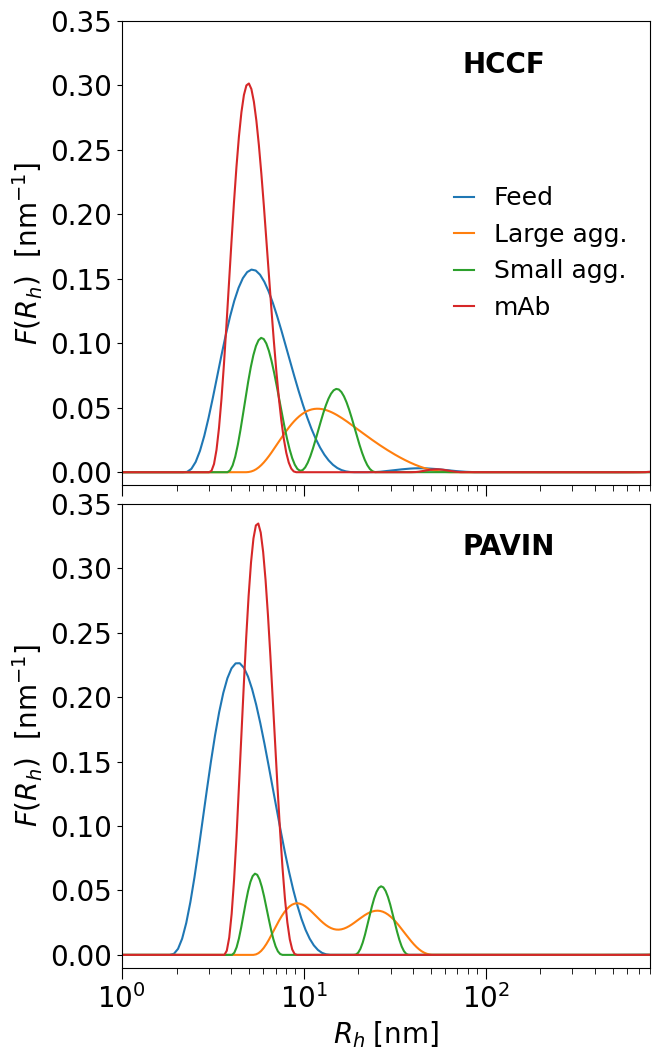

In [23]:
fig, ax = plt.subplots(2, sharex=True, sharey=True)
fig.set_size_inches(7, 11, forward=True)
ax[0].set_xlim(1, 800)

normalize = False
trim = False

# normalize = True
# trim = True

if normalize:
    ax[0].set_ylim(-0.02, 1.05)
    y_text_pos = 0.95
else:
    ax[0].set_ylim(-0.01, 0.35)
    y_text_pos = 0.31

ax[1].set_xlabel(r'$R_h \;$[nm]')

for i in range(2):
    ax[i].tick_params(axis='x', which='major', size=8)
    ax[i].tick_params(axis='x', which='minor', size=4)
    if normalize:
        ax[i].set_ylabel(r'$F(R_h) \; / \; F_{max}$')
    else:
        ax[i].set_ylabel(r'$F(R_h)$  [nm$^{-1}$]')

for i, name in enumerate(['hccf_feed_native', 'hccf_large_700', 'hccf_small_700', 'hccf_mab_700']):
    fig, ax[0] = data[name].make_rh_dist_plot(fig, ax[0], labels[i], normalize=normalize, trim=trim)

for i, name in enumerate(['pafvin_feed_native', 'pafvin_large_500', 'pafvin_small_250', 'pafvin_mab_750']):
    fig, ax[1] = data[name].make_rh_dist_plot(fig, ax[1], labels[i], normalize=normalize, trim=trim)

plt.subplots_adjust(hspace=0.04)

t = ax[0].annotate('HCCF', xytext=(75, y_text_pos), xy=(10, 0.2), fontsize=20, weight='bold')
t = ax[1].annotate('PAVIN', xytext=(75, y_text_pos), xy=(10, 0.2), fontsize=20, weight='bold')
legend = ax[0].legend(handlelength=0.8, frameon=False, fontsize=18, handletextpad=0.8, loc='center right')  

plt.savefig(f'./{images_folder}/All_HCCF_and_PAFVIN_7_Rh_dist.png', dpi=300, bbox_inches='tight')
plt.savefig(f'./{images_folder}/All_HCCF_and_PAFVIN_7_Rh_dist.tif', dpi=300, bbox_inches='tight')
plt.savefig(f'./{images_folder}/All_HCCF_and_PAFVIN_7_Rh_dist.eps', dpi=300, bbox_inches='tight')

# plt.savefig(f'./{images_folder}/All_HCCF_and_PAFVIN_7_Rh_dist_trimmed_normalized.png', dpi=300, bbox_inches='tight')

In [120]:
for name in data.keys():
    print(f'{data[name].average_count_rate_kHz * data[name].duration_s * 1e3:.2e}, {name}')

4.72e+07, hccf_feed_native
1.40e+08, hccf_feed_700
1.95e+08, hccf_large_700
1.43e+08, hccf_small_700
1.15e+08, hccf_mab_700
1.22e+08, hccf_mab_3643
6.48e+07, pafvin_feed_native
1.51e+08, pafvin_large_500
2.05e+08, pafvin_small_250
1.25e+08, pafvin_mab_750
